In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class MultiTaskNet(nn.Module):
    def __init__(self, input_size):
        super(MultiTaskNet, self).__init__()
        self.shared_layer = nn.Linear(input_size * 2, 10)

        # Task 1 specific layers
        self.task1_layer = nn.Linear(10, 10)
        self.output1 = nn.Linear(10, 2)

        # Task 2 specific layers
        self.task2_layer = nn.Linear(10, 10)
        self.output2 = nn.Linear(10, 2)

    def forward(self, x):
        x = torch.relu(self.shared_layer(x))

        task1_out = torch.relu(self.task1_layer(x))
        task1_out = self.output1(task1_out)

        task2_out = torch.relu(self.task2_layer(x))
        task2_out = self.output2(task2_out)

        return task1_out, task2_out


In [ ]:
class Task1Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class Task2Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [ ]:
import random

# Predefined dictionary for Task 1
predetermined_ordering = {
    0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    1: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    2: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    3: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    4: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    5: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    6: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    7: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    8: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    9: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
}

def generate_task1_data(num_samples, input_size):
    # data = []
    # labels = []
    # for _ in range(num_samples):
    #     idx1, idx2 = random.sample(range(input_size), 2)
    #     vector1 = predetermined_ordering[idx1]
    #     vector2 = predetermined_ordering[idx2]
    #     data.append(vector1 + vector2)
    #     labels.append(0 if idx1 < idx2 else 1)

    data = []
    labels = []
    for _ in range(num_samples):
        dict_indices = random.sample(range(input_size), 2)
        random.shuffle(dict_indices)
        item1, item2 = [predetermined_ordering[i] for i in dict_indices]
        data.append(item1 + item2)
        target = 0 if dict_indices[0] < dict_indices[1] else 1
        labels.append(target)
    return torch.tensor(data).float(), torch.tensor(labels).long()

def generate_task2_data(num_samples, input_size):
    data = []
    labels = []
    for _ in range(num_samples):
        vector1 = [random.randint(0, 1) for _ in range(input_size)]
        vector2 = [max(a, b) for a, b in zip(vector1, [random.randint(0, 1) for _ in range(input_size)])]
        if random.random() > 0.5:
            data.append(vector1 + vector2)
            labels.append(0)
        else:
            data.append(vector2 + vector1)
            labels.append(1)
    return torch.tensor(data).float(), torch.tensor(labels).long()

num_samples = 10
input_size = 10

# Generate data
data1, labels1 = generate_task1_data(num_samples, input_size)
data2, labels2 = generate_task2_data(num_samples, input_size)

dataset1 = Task1Dataset(data1, labels1)
dataset2 = Task2Dataset(data2, labels2)

loader1 = DataLoader(dataset1, batch_size=100, shuffle=True)
loader2 = DataLoader(dataset2, batch_size=100, shuffle=True)


In [ ]:
def interleave_batches(loader1, loader2):
    iter1 = iter(loader1)
    iter2 = iter(loader2)
    while True:
        try:
            data1, labels1 = next(iter1)
        except StopIteration:
            iter1 = iter(loader1)
            data1, labels1 = next(iter1)
        try:
            data2, labels2 = next(iter2)
        except StopIteration:
            iter2 = iter(loader2)
            data2, labels2 = next(iter2)
        yield data1, labels1, data2, labels2


In [ ]:
model = MultiTaskNet(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1
interleaved_loader = interleave_batches(loader1, loader2)

losses_ti = []
losses_si = []
losses = []

for epoch in range(num_epochs):
    model.train()
    for i, (data1, labels1, data2, labels2) in enumerate(interleaved_loader):
        optimizer.zero_grad()

        # Forward pass for Task 1
        outputs1, _ = model(data1)
        loss1 = criterion(outputs1, labels1)

        # Forward pass for Task 2
        _, outputs2 = model(data2)
        loss2 = criterion(outputs2, labels2)

        # Backward pass and optimization
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        losses_ti.append(loss1.item())
        losses_si.append(loss2.item())
        losses.append(loss.item())

        if i % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}], Loss: {loss.item():.4f}")


Epoch [1/1], Step [0], Loss: 1.2703
Epoch [1/1], Step [1000], Loss: 0.0609
Epoch [1/1], Step [2000], Loss: 0.0233
Epoch [1/1], Step [3000], Loss: 0.0113


KeyboardInterrupt: 

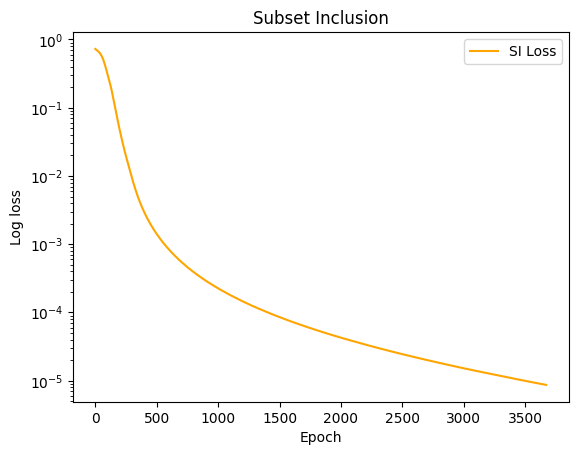

In [ ]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.title('Subset Inclusion')
# plt.plot(losses_ti, label='TI Loss')
plt.plot(losses_si, label='SI Loss', color='orange')
# plt.plot(losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.legend()
plt.show()

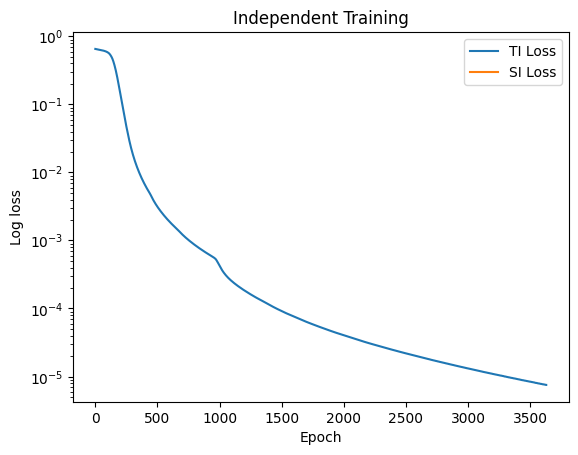

In [ ]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.title('Independent Training')
plt.plot(losses_ti, label='TI Loss')
plt.plot(losses_si, label='SI Loss')
# plt.plot(losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.legend()
plt.show()

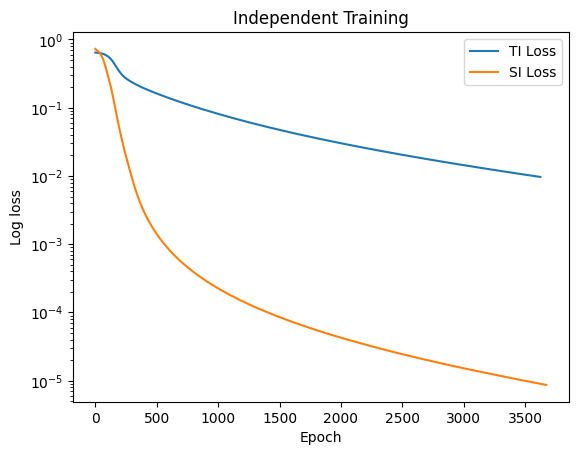

In [ ]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.title('Independent Training')
plt.plot(losses_ti, label='TI Loss')
plt.plot(losses_si, label='SI Loss')
# plt.plot(losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.legend()
plt.show()

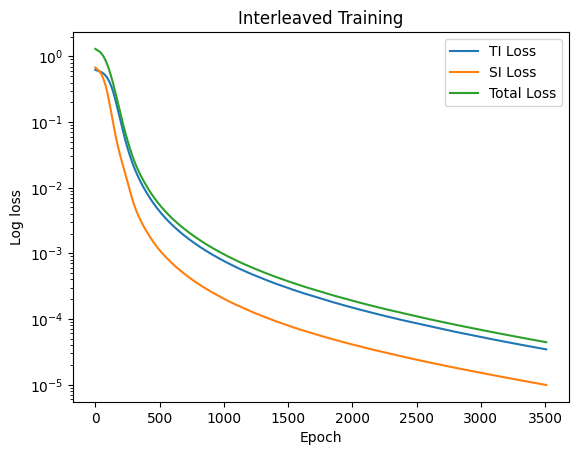

In [ ]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.title('Interleaved Training')
plt.plot(losses_ti, label='TI Loss')
plt.plot(losses_si, label='SI Loss')
plt.plot(losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.legend()
plt.show()

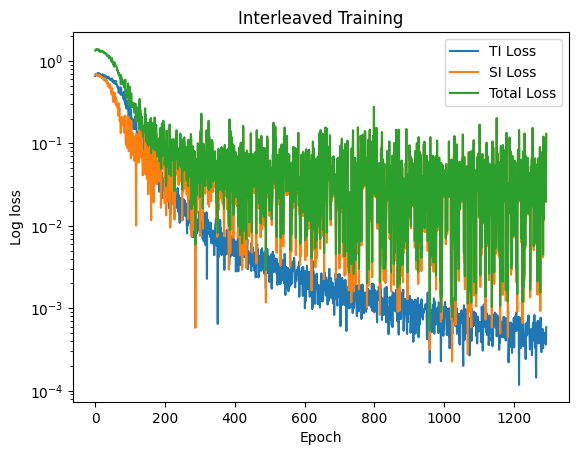

In [ ]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.title('Interleaved Training')
plt.plot(losses_ti, label='TI Loss')
plt.plot(losses_si, label='SI Loss')
plt.plot(losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.legend()
plt.show()

In [ ]:
#@title Save the model weights
torch.save(model.state_dict(), '/content/interleaved_weights_100')
!cp '/content/interleaved_weights_100' '/content/drive/MyDrive/NMA_NeuroAI/interleaved_weights_100'

In [ ]:
#@title Save the model weights
torch.save(model.state_dict(), '/content/ti_weights_100')
!cp '/content/ti_weights_100' '/content/drive/MyDrive/NMA_NeuroAI/ti_weights_100'

In [ ]:
#@title Save the model weights
torch.save(model.state_dict(), '/content/si_weights_100')
!cp '/content/si_weights_100' '/content/drive/MyDrive/NMA_NeuroAI/si_weights_100'